In [ ]:

#!pip install pytorch-tabnet wget
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import os
import wget
from pathlib import Path
import shutil
import gzip

import gc

random_state=42
np.random.seed(random_state)

from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv('data/DNN-EdgeIIoT-dataset.csv', low_memory=False)
drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4", 
         "http.file_data","http.request.full_uri","icmp.transmit_timestamp",
         "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",
         "tcp.dstport", "udp.port", "mqtt.msg"]

df.drop(drop_columns, axis=1, inplace=True)
df.dropna(axis=0, how='any', inplace=True)
df.drop_duplicates(subset=None, keep="first", inplace=True)
df = shuffle(df)

categorical_columns = []
for col in df.columns[df.dtypes == object]:
    if col != "Attack_type":
        categorical_columns.append(col)

featuresFromStart = [ col for col in df.columns if col not in ["Attack_label"]+["Attack_type"]]
#print("-----Features from the start-----")
#print(featuresFromStart)
#print("-----Categorial features-----")
#print(categorical_columns)
#Display information about dataframe
def displayInformationDataFrame(df_cop):
    summary_df = pd.DataFrame(columns=['Data Type', 'Column Name', 'Unique Values'])
    # Iterate through the columns of the original dataframe
    for col in df_cop.columns:
        # Get the data type of the column
        dtype = df_cop[col].dtype
        # Get the column name
        col_name = col
        # Get the unique values of the column
        unique_values = df_cop[col].unique()
        # Append a new row to the summary dataframe
        summary_df = summary_df.append({'Data Type': dtype, 'Column Name': col_name, 'Unique Values': unique_values}, ignore_index=True)
    # display the summary_df
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    return display(summary_df)
    
displayInformationDataFrame(df)

colunas_one_hot = {}
for coluna in categorical_columns:
    codes, uniques = pd.factorize(df[coluna].unique())
    colunas_one_hot[coluna] = {"uniques": uniques, "codes":codes}
    df[coluna] = df[coluna].replace(colunas_one_hot[coluna]["uniques"], colunas_one_hot[coluna]["codes"])
    print(coluna)
df = pd.get_dummies(data=df, columns=categorical_columns)
displayInformationDataFrame(df)

df = shuffle(df)
n_total = len(df)

features = [ col for col in df.columns if col not in ["Attack_label"]+["Attack_type"]] 

le = LabelEncoder()
le.fit(df["Attack_type"].values)

train_val_indices, test_indices = train_test_split(range(n_total), test_size=0.2, random_state=random_state)
train_indices, valid_indices = train_test_split(train_val_indices, test_size=0.25, random_state=random_state) # 0.25 x 0.8 = 0.2

X_train = df[features].values[train_val_indices]
y_train = df["Attack_type"].values[train_val_indices]
y_train = le.transform(y_train)

X_valid = df[features].values[valid_indices]
y_valid = df["Attack_type"].values[valid_indices]
y_valid = le.transform(y_valid)

X_test = df[features].values[test_indices]
y_test = df["Attack_type"].values[test_indices]
y_test = le.transform(y_test)

standScaler = StandardScaler()
model_norm = standScaler.fit(X_train)

X_train = model_norm.transform(X_train)
X_test = model_norm.transform(X_test)
X_valid = model_norm.transform(X_valid)

del df
gc.collect()

sm = SMOTE(random_state=random_state,n_jobs=1,k_neighbors=1)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Network parameters

In [9]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=[],
    cat_dims=[],
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95, "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/Users/melicias/.local/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


# Training

In [10]:
max_epochs = 5 if not os.getenv("CI", False) else 2

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256
) 

epoch 0  | loss: 0.67845 | train_accuracy: 0.76022 | valid_accuracy: 0.73235 |  0:43:54s
epoch 1  | loss: 0.50141 | train_accuracy: 0.73658 | valid_accuracy: 0.05    |  1:30:01s
epoch 2  | loss: 0.50056 | train_accuracy: 0.7607  | valid_accuracy: 0.77096 |  2:14:49s
epoch 3  | loss: 0.48351 | train_accuracy: 0.75355 | valid_accuracy: 0.71342 |  2:56:57s
epoch 4  | loss: 0.48878 | train_accuracy: 0.75752 | valid_accuracy: 0.77493 |  3:39:36s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_accuracy = 0.77493


/Users/melicias/.local/lib/python3.7/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


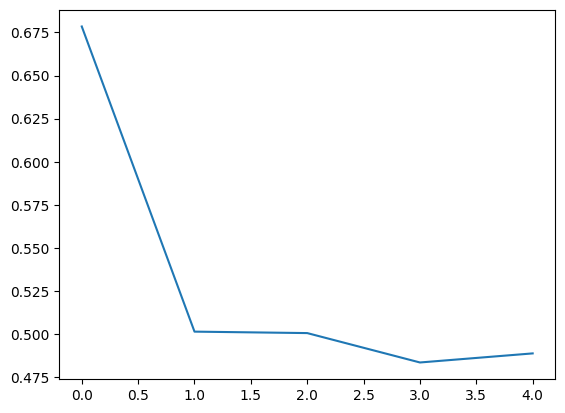

In [12]:
# plot losses
plt.plot(clf.history['loss'])

In [13]:
# plot accuracy
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

KeyError: 'train_auc'

### Predictions


In [14]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR : {test_acc}")

BEST VALID SCORE FOR : 0.7749291329786492
FINAL TEST SCORE FOR : 0.90369846720079


In [15]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR : {test_acc}")

FINAL TEST SCORE FOR : 0.90369846720079


# Save and load Model

In [11]:
# save state dict
saved_filename = clf.save_model('modelEdgeIIotMulti')

Successfully saved model at modelEdgeIIotMulti.zip


In [16]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

/Users/melicias/.local/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [17]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR : {loaded_test_acc}")

FINAL TEST SCORE FOR : 0.90369846720079


In [22]:
assert(test_acc == loaded_test_acc)

# Global explainability : feat importance summing to 1

In [23]:
clf.feature_importances_

array([0.00000000e+00, 1.45627935e-07, 0.00000000e+00, 3.73413370e-06,
       0.00000000e+00, 1.90664001e-08, 0.00000000e+00, 7.62556430e-06,
       1.49916689e-02, 0.00000000e+00, 0.00000000e+00, 1.07002085e-10,
       2.00572687e-03, 3.76105274e-03, 8.16230641e-04, 1.26871948e-03,
       2.63493621e-04, 2.27922184e-04, 8.39143706e-08, 3.38405570e-04,
       1.53683257e-05, 1.57668041e-05, 6.34653091e-05, 4.75393752e-07,
       0.00000000e+00, 1.13014865e-03, 0.00000000e+00, 4.79628949e-03,
       7.07696177e-02, 1.12348922e-02, 0.00000000e+00, 1.95827880e-07,
       1.22446883e-06, 2.07415893e-04, 7.09345140e-04, 0.00000000e+00,
       0.00000000e+00, 2.66179334e-03, 8.95892509e-03, 0.00000000e+00,
       0.00000000e+00, 5.56419720e-02, 2.21003384e-03, 3.55836237e-07,
       0.00000000e+00, 1.37331138e-04, 3.14071116e-03, 6.87560052e-04,
       0.00000000e+00, 3.11206580e-02, 1.13172337e-02, 1.12866337e-03,
       0.00000000e+00, 2.10934710e-03, 7.81403206e-02, 1.22867869e-04,
      

# Local explainability and masks

In [18]:
explain_matrix, masks = clf.explain(X_test)

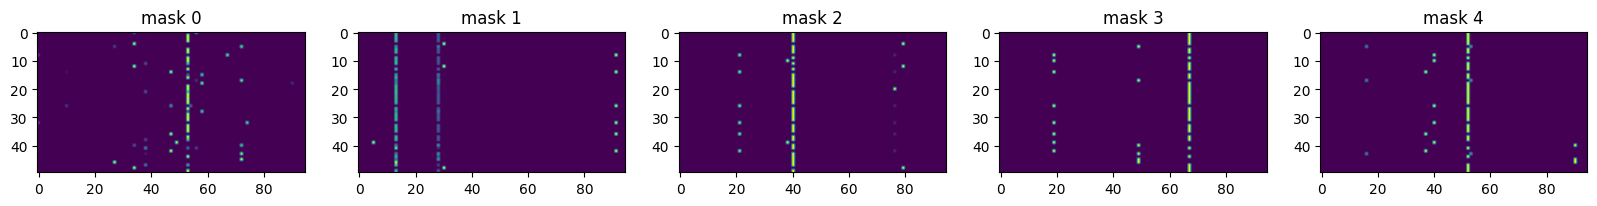

In [19]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGB

In [2]:
n_estimators = 100 if not os.getenv("CI", False) else 20

In [3]:
print((le.classes_).size)

15


In [4]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="multi:softmax",
    #objective="multi:softprob",
    booster='gbtree',
    n_jobs=1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=random_state,
    seed=None,
    num_class= (le.classes_).size)
    #num_class= 2)

In [6]:
clf_xgb.load_model('./XGBClassifierInOneGo.json')
#clf_xgb.fit(X_train, y_train,
#            eval_set=[(X_valid, y_valid)],
#            early_stopping_rounds=40,
#            verbose=10)

In [7]:
preds_valid = np.array(clf_xgb.predict(X_valid))
valid_acc = accuracy_score(y_pred=preds_valid, y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf_xgb.predict(X_test))
test_acc = accuracy_score(y_pred=preds_test, y_true=y_test)
print(test_acc)

0.0650243235742301
0.984811551703824


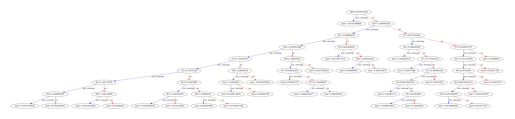

In [12]:
from xgboost import plot_tree
plot_tree(clf_xgb)
plt.show()

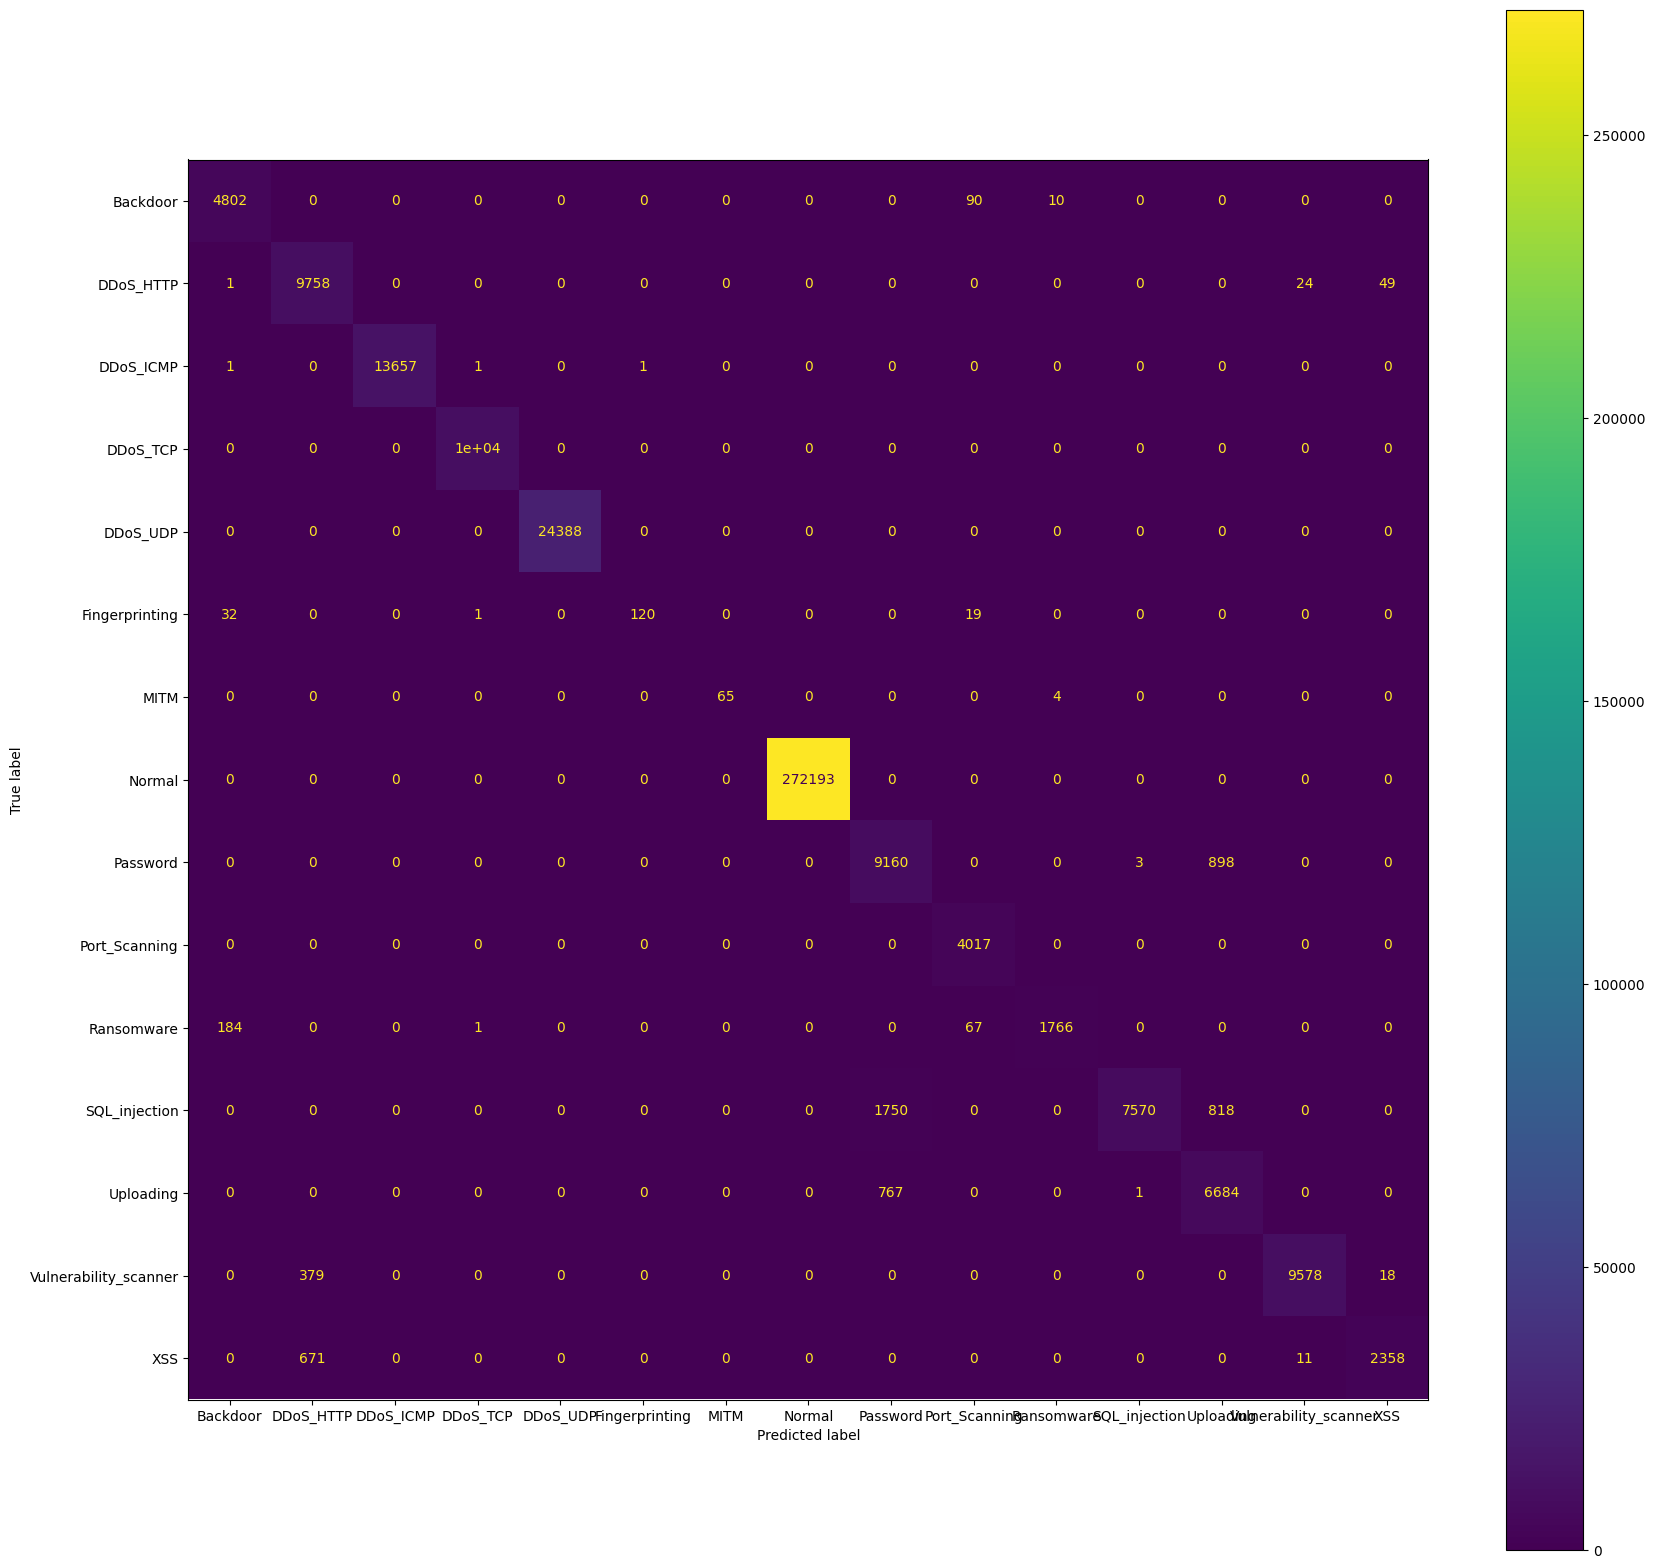

In [16]:
from sklearn import metrics
original_labels_list = le.classes_
fig,ax = plt.subplots(figsize=(20, 20))
confusion_matrix = metrics.confusion_matrix(y_test, preds_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels= original_labels_list)
cm_display.plot(ax=ax)
plt.savefig("confusion_matrixOneGo.png")
plt.show()

In [18]:
clf_xgb.load_model('./XGBClassifierSeparated.json')
preds_valid = np.array(clf_xgb.predict(X_valid))
valid_acc = accuracy_score(y_pred=preds_valid, y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf_xgb.predict(X_test))
test_acc = accuracy_score(y_pred=preds_test, y_true=y_test)
print(test_acc)

0.750171495598716
0.9830835089740401


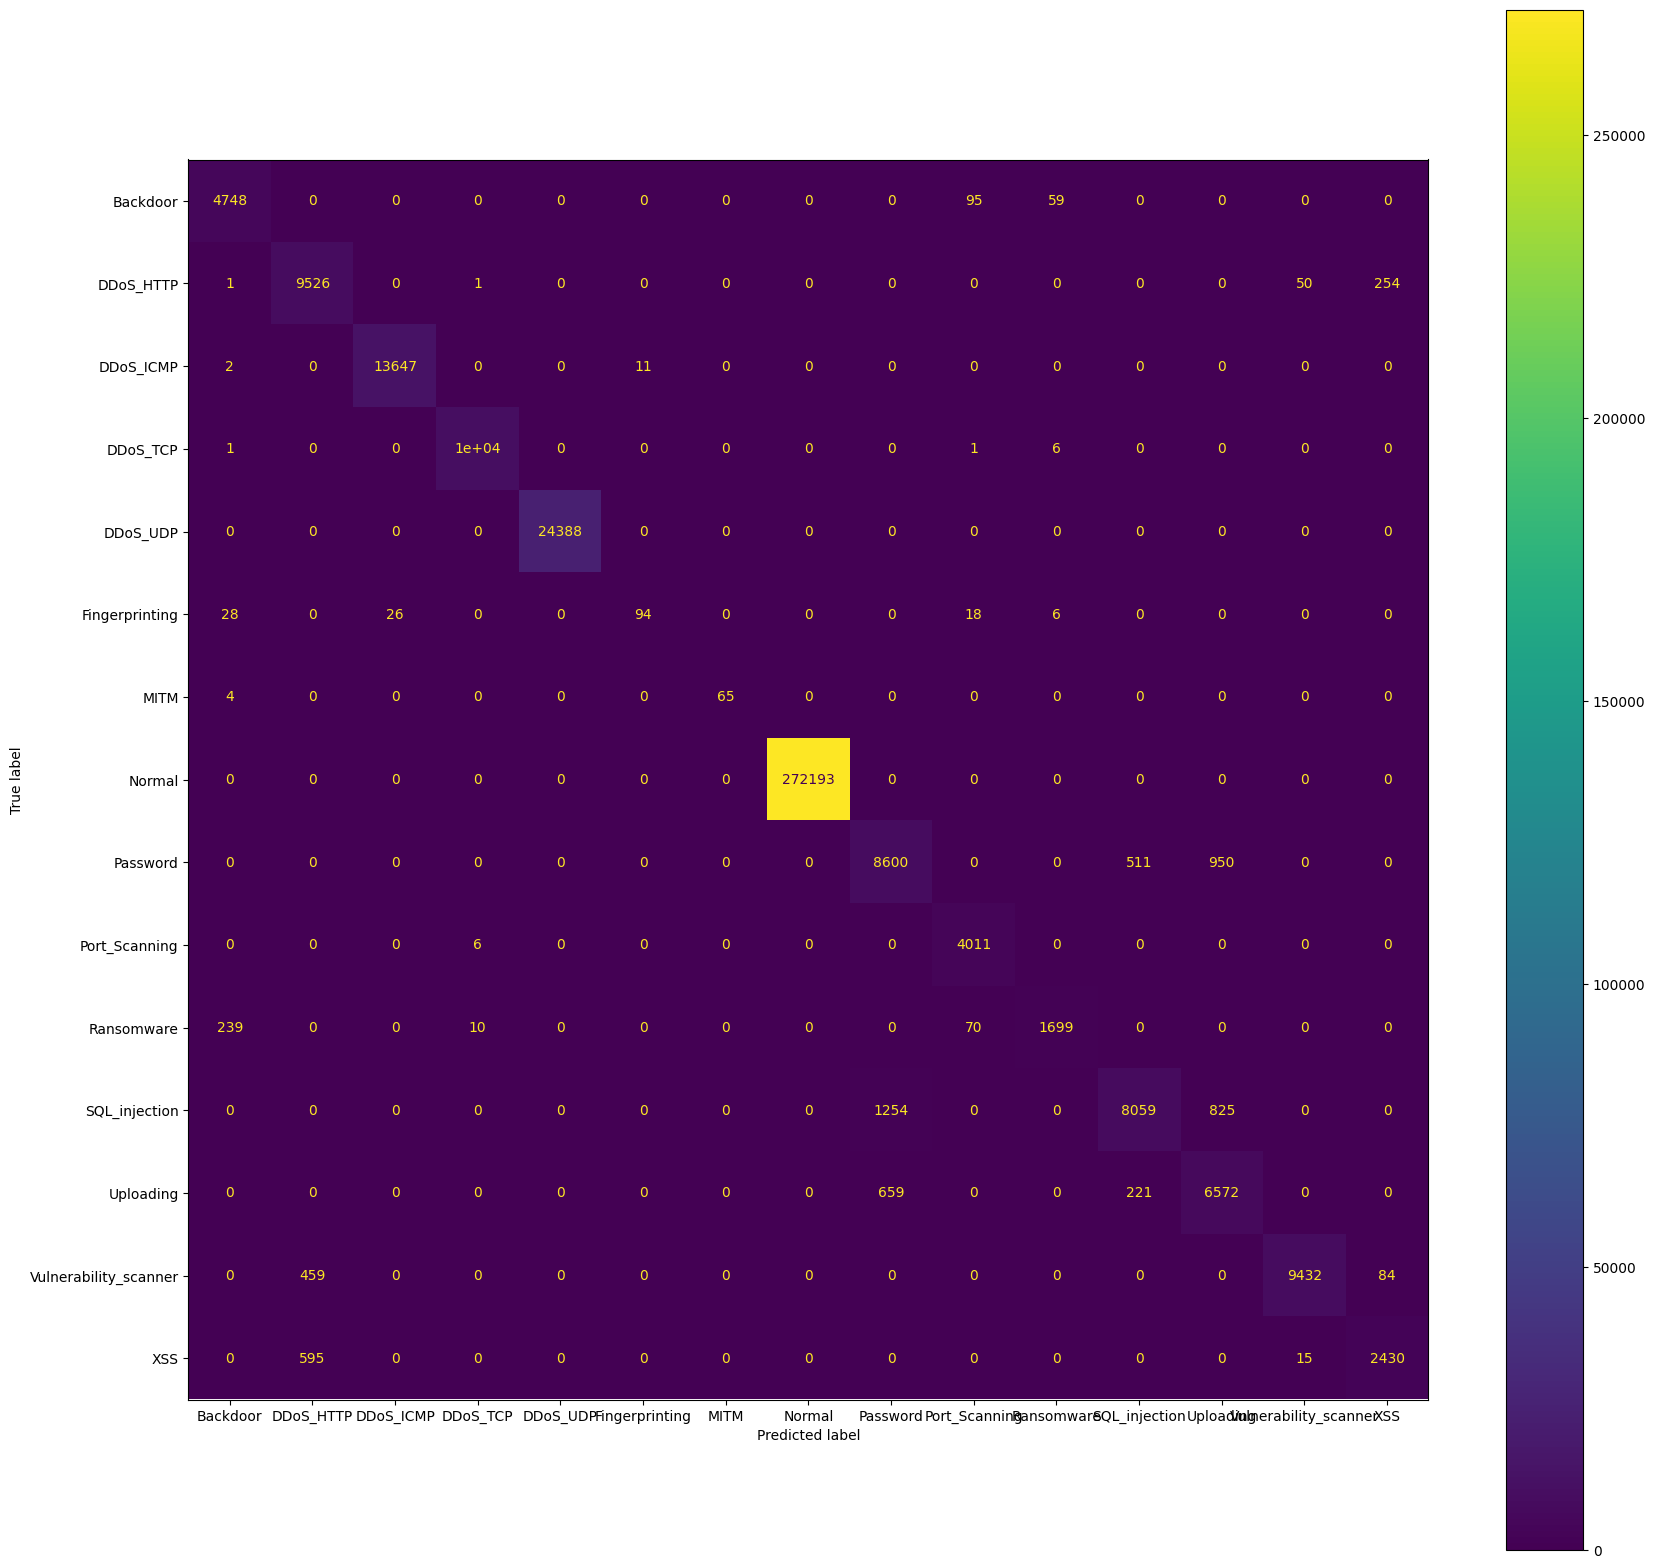

In [19]:
from sklearn import metrics
original_labels_list = le.classes_
fig,ax = plt.subplots(figsize=(20, 20))
confusion_matrix = metrics.confusion_matrix(y_test, preds_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels= original_labels_list)
cm_display.plot(ax=ax)
plt.savefig("confusion_matrixOneGo.png")
plt.show()

In [8]:
preds_valid = np.array(clf_xgb.predict(X_valid))
valid_acc = accuracy_score(y_pred=np.argmax(preds_valid, axis=1) + 1, y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_pred=np.argmax(preds_test, axis=1) + 1, y_true=y_test)
print(test_acc)

AxisError: axis 1 is out of bounds for array of dimension 1